# Notebook- Visualize covnet filters : Model14_2
# Author : V.Albors   Date : 23.11.2019
# Purpose : Visualize covnet filters


**Input** :  
  * Model 1_1
  * 
  
**Output**:  
  * Visualize covnet filters
  * 

**Process**:  
  * 
 



In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

tf.keras.backend.clear_session()  # Reset

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU') 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.debugging.set_log_device_placement(False)

In [ ]:
#Tensorflow version 
print(tf.__version__)
from tensorflow.python.platform import build_info as tf_build_info
print(tf_build_info.cuda_version_number)
# Cuda Version 9.0 in v1.10.0
print(tf_build_info.cudnn_version_number)
# CudNN 7 in v1.10.0

In [2]:
# Define the name of the model, directories & if to train the model 
Model_directory = "MODELK14"
Model_name = "Model14_2"

In [3]:
# Import routines
import sys  
subrc_dir = "/home/valborsf/Documents/UOC/PFMProject/"

sys.path.append(subrc_dir)  
from  Models_routines import *
import inspect

# List functions inside the module
import Models_routines as module
functions = inspect.getmembers(module, inspect.isfunction)
lsfunctions = [item[0] for item in functions]
print ( lsfunctions )

['confusion_ROC_AUC', 'create_column_tensor', 'create_label_tensor', 'define_dirs', 'load_hist_model', 'load_images', 'model_load', 'plot_save_acc_loss', 'print_network', 'process_clinical_info', 'read_dataframes', 'read_dataframes_tables', 'save_model', 'save_network_json', 'start', 'stop', 'to_one_hot', 'to_one_hot_words', 'xi_squared']


In [4]:
# Define directories
(root_dir,json_dir,imag_dir,csv_dir,model_json_dir,model_bin_dir,results_dir,Tensor_dir) = define_dirs(Model_directory)

In [ ]:
# New dataset without SONIC disturbing images
json_dir =  root_dir +"/DataNew/ALL_JSON/"                # .json dir images
imag_dir =  root_dir +"/DataNew/ALL_IMAGES/"              # .png dir - images

# directories for  CSV's
csv_dir =  root_dir +"/DataNew4/CSV/"                      # .csv dir - dftrain, dfval, dftest

In [5]:
from keras.preprocessing import image
import numpy as np
import pandas as pd 


dftrain = pd.DataFrame()     
dftrain = pd.read_csv(csv_dir+'dftrain.csv')
print(dftrain.shape )


# One image dir 
#image_number = 120  # Select the number of image -image with mark
image_number = 60  # Select the number of image
one_imag_dir  = imag_dir + dftrain['file_name_ext'][image_number]
print ( one_imag_dir)


img = image.load_img (one_imag_dir, target_size=(150,150))
img_tensor = image.img_to_array (img)
img_tensor = np.expand_dims ( img_tensor, axis = 0)
img_tensor /= 255.
print (img_tensor.shape)

(2056, 9)
/home/user/Documentos/UOC/PFM/PFMProject/Data/ALL_IMAGES/ISIC_0033771.jpg
(1, 150, 150, 3)


Using TensorFlow backend.


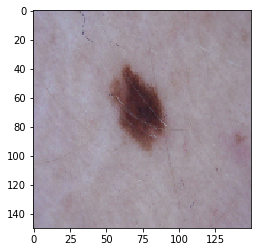

In [7]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [8]:
# Load model ( copy of Model 1 )
model = model_load(model_bin_dir, Model_name)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [17]:
from keras import models 
# Extract the outputs of the top eight layers
#layer_outputs = [layer.output for layer in model.layers[:8]]
#print ( type ( layer_outputs))
#print ( layer_outputs[0])

# print the layer names in model :
#for layer in model.layers:
#    print(layer.name)

# print the first layer name 
first_layer = model.layers[0].name
print ( first_layer)

layer_output = model.get_layer(first_layer).output
print ( layer_output)

conv2d_1
Tensor("conv2d_1/Relu:0", shape=(?, 148, 148, 32), dtype=float32)


In [18]:
from keras import backend as K
filter_index = 0 
loss = K.mean(layer_output[:, :, :, filter_index ] )   #loss for the activation of filter 0 in layer conv2d_1

In [19]:
# gradient of the loss with respect to the model input 
grads = K.gradients(loss, model.input)[0]

In [21]:
print ( model.input)

Tensor("conv2d_1_input:0", shape=(?, 150, 150, 3), dtype=float32)


In [ ]:
# Gradient normalization trick 
grads /= (K.sqrt(K.mean(K.square(grads)))  + 1.e-5)

In [22]:
# Fetching Numpy output values given Numpy input values 
# iterate is a function that takes a Numpy tensor  (as a list of tensors of size 1)and 
# returns a list of 2 Numpy tensors : the loss value and the gradient
iterate = K.function([model.input], [loss,grads])

In [23]:
import numpy as np
loss_value, grads_value = iterate ( [np.zeros((1,150,150,3))])

In [30]:
# Loss maximization via stochastic gradient descent
# The resulting image is a tensor of shape ( 1,150, 150,3 ) with values that may not be integers within [0,255]
input_img_data = np.random.random ((1,150,150,3)) * 20 + 128. # grey image with some noise

step = 1.
for i in range (40):
    loss_value, grads_value = iterate ([input_img_data])
    input_img_data += grads_value * step

print (input_img_data.shape)
#print ( input_img_data[0])

(1, 150, 150, 3)


In [28]:
# Postprocess tensor to turn into displayable image

def deprocess_image(x):
    x -= x.mean()                          # Normalizes the tensor:
    x /= (x.std() + 1.e-5)                 # centers on 0
    x *= 0.1                               # ensures that std is 0.1
    
    x += 0.5                               # Clips to [0,1]
    x = np.clip (x, 0, 1)
    
    x *= 255                               # Converts to an RGB array
    x = np.clip(x, 0, 255).astype('uint8')
    return x

(150, 150, 3)


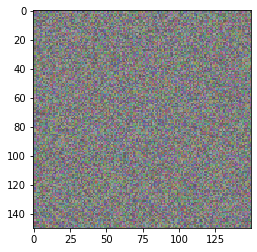

In [32]:
img = input_img_data[0]
dep_img = deprocess_image(img)
plt.imshow (dep_img)
print ( dep_img.shape)


In [92]:
# generate a function 

def generate_pattern(layer_name, filter_index, size = 150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index ] )
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads)))  + 1.e-5)
    
    iterate = K.function([model.input], [loss,grads])
    input_img_data = np.random.random ((1,size,size,3)) * 20 + 128. 
    step = 1.
    for i in range (40):
        loss_value, grads_value = iterate ([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
   
    return deprocess_image(img) 

conv2d_1


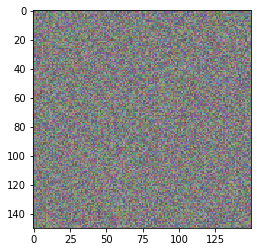

In [61]:
first_layer = model.layers[0].name
print ( first_layer)
plt.imshow ( generate_pattern ( first_layer,0 ))

max_pooling2d_1


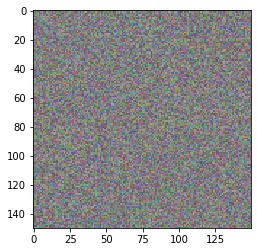

In [62]:
second_layer = model.layers[1].name
print ( second_layer)
plt.imshow ( generate_pattern ( second_layer,0 ))

conv2d_2


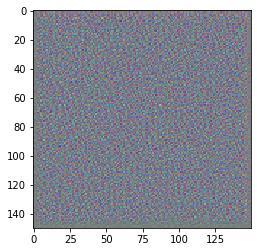

In [63]:
third_layer = model.layers[2].name
print ( third_layer)
plt.imshow ( generate_pattern (third_layer,0 ))

conv2d_1


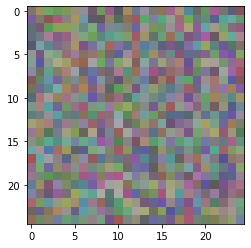

In [64]:
first_layer = model.layers[0].name
print ( first_layer)
plt.imshow ( generate_pattern ( first_layer,0,25 ))

conv2d_1


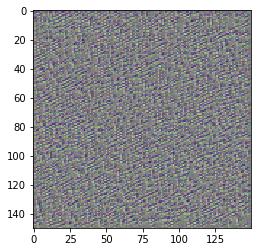

In [116]:
first_layer = model.layers[0].name
print ( first_layer)
plt.imshow ( generate_pattern ( first_layer,5,150 ))

conv2d_4


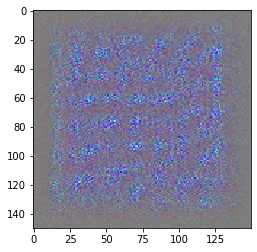

In [132]:
layer_name = model.layers[6].name
print ( layer_name)
filter_index = 10
plt.imshow ( generate_pattern ( layer_name,filter_index,150 ))

Layer : conv2d_1  First 25 filters 
Filters vertical : 0,1,2,3,4,5


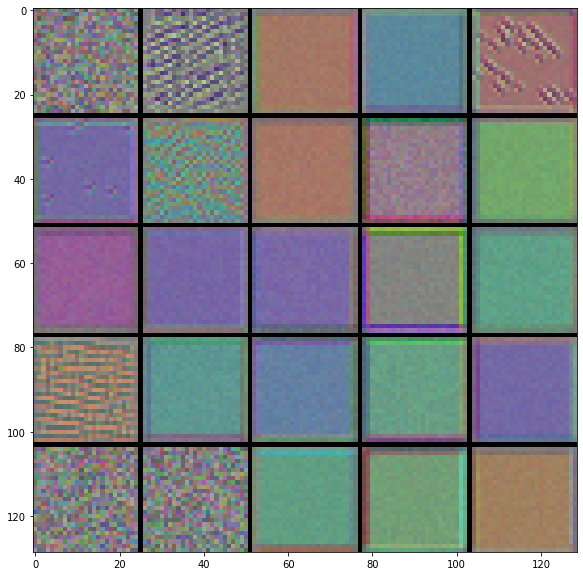

In [67]:
# Look at the first 25=5x5 filters in the first layer 

# First layer : 'conv2d_1'
layer_name = model.layers[0].name


size = 25
margin = 1

results = np.zeros(( 5*size + 4* margin,  5*size + 4*margin, 3))

for i in range(5):
    for j in range (5):
        filter_index = i + (j*5)
        filter_img = generate_pattern (layer_name, filter_index, size=size)
        
        horizontal_start = i* size + i*margin
        horizontal_end = horizontal_start + size
        
        vertical_start = j*size + j*margin
        vertical_end = vertical_start + size
        
        results[horizontal_start:horizontal_end, 
                vertical_start:vertical_end, :]=filter_img
        

# Display results grid
print ( 'Layer :', layer_name, ' First 25 filters ')
print ( 'Filters vertical : 0,1,2,3,4,5')
plt.figure (figsize=(10,10))
plt.imshow(results.astype('uint8'))


Layer : conv2d_2  First 25 filters 
Filters vertical : 0,1,2,3,4,5


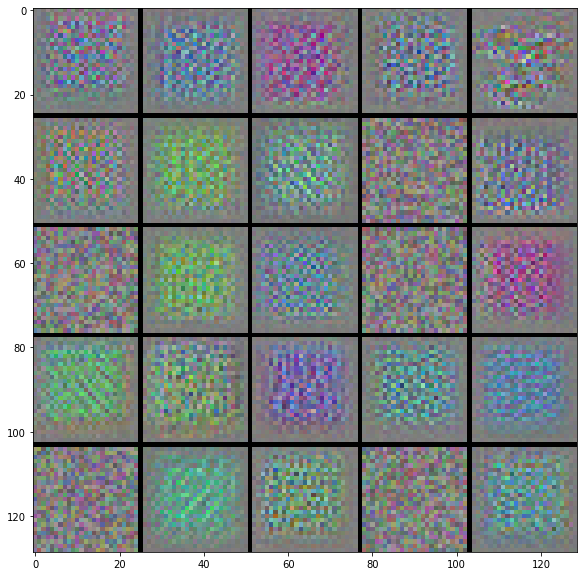

In [68]:
# Look at the first 25=5x5 filters in the Second conv layer 

# Second layer : 'conv2d_2'
layer_name = model.layers[2].name


size = 25
margin = 1

results = np.zeros(( 5*size + 4* margin,  5*size + 4*margin, 3))

for i in range(5):
    for j in range (5):
        filter_index = i + (j*5)
        filter_img = generate_pattern (layer_name, filter_index, size=size)
        
        horizontal_start = i* size + i*margin
        horizontal_end = horizontal_start + size
        
        vertical_start = j*size + j*margin
        vertical_end = vertical_start + size
        
        results[horizontal_start:horizontal_end, 
                vertical_start:vertical_end, :]=filter_img
        

# Display results grid
print ( 'Layer :', layer_name, ' First 25 filters ')
print ( 'Filters vertical : 0,1,2,3,4,5')
plt.figure (figsize=(10,10))
plt.imshow(results.astype('uint8'))


Layer : conv2d_3  First 25 filters 
Filters vertical : 0,1,2,3,4,5


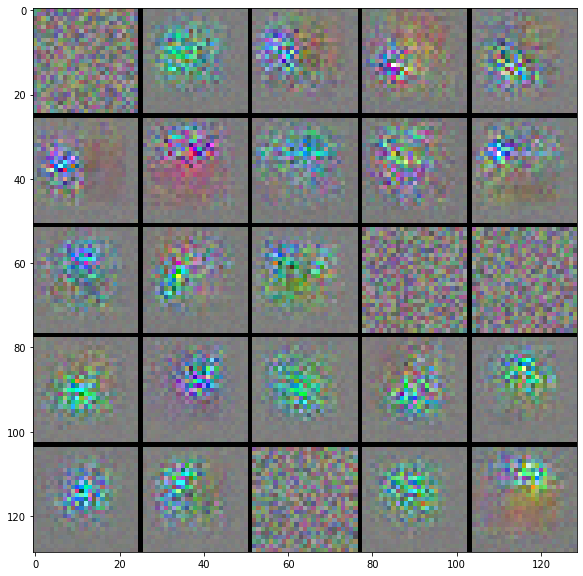

In [69]:
# Look at the first 25=5x5 filters in the Third conv layer 

# Third layer : 'conv2d_3'
layer_name = model.layers[4].name


size = 25
margin = 3

results = np.zeros(( 5*size + 4* margin,  5*size + 4*margin, 3))

for i in range(5):
    for j in range (5):
        filter_index = i + (j*5)
        filter_img = generate_pattern (layer_name, filter_index, size=size)
        
        horizontal_start = i* size + i*margin
        horizontal_end = horizontal_start + size
        
        vertical_start = j*size + j*margin
        vertical_end = vertical_start + size
        
        results[horizontal_start:horizontal_end, 
                vertical_start:vertical_end, :]=filter_img
        

# Display results grid
print ( 'Layer :', layer_name, ' First 25 filters ')
print ( 'Filters vertical : 0,1,2,3,4,5')
plt.figure (figsize=(10,10))
plt.imshow(results.astype('uint8'))


In [ ]:
# Images SIZE = 150 

conv2d_1
Layer : conv2d_1  First 36 filters 
Filters vertical : 0,1,2,3,4,5,6


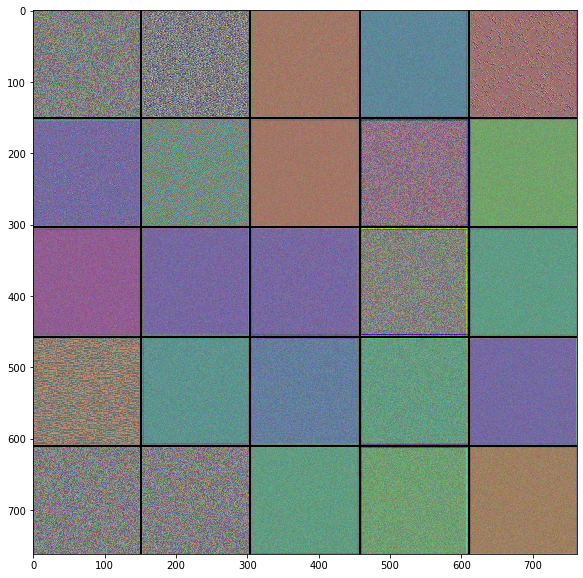

In [144]:
# Look at the first 25=5x5 filters in the First. Size = 150
# Can not be more that 32 filters !!!!!

# First layer : 'conv2d_1'
layer_name = model.layers[0].name
print(layer_name)


margin = 3
size_imag = 150

results = np.zeros(( 5*size_imag + 4* margin,  5*size_imag + 4*margin, 3))

for i in range(5):
    for j in range (5):
        filter_index = i + (j*5)

        filter_img = generate_pattern (layer_name, filter_index, size=size_imag)
         
        horizontal_start = i* size_imag + i*margin
        horizontal_end = horizontal_start + size_imag
        
        vertical_start = j*size_imag + j*margin
        vertical_end = vertical_start + size_imag
        
        results[horizontal_start:horizontal_end, 
                vertical_start:vertical_end, :]=filter_img
        

# Display results grid
print ( 'Layer :', layer_name, ' First 36 filters ')
print ( 'Filters vertical : 0,1,2,3,4,5,6')
plt.figure (figsize=(10,10))
plt.imshow(results.astype('uint8'))

conv2d_2
Layer : conv2d_2  First 36 filters 
Filters vertical : 0,1,2,3,4,5,6


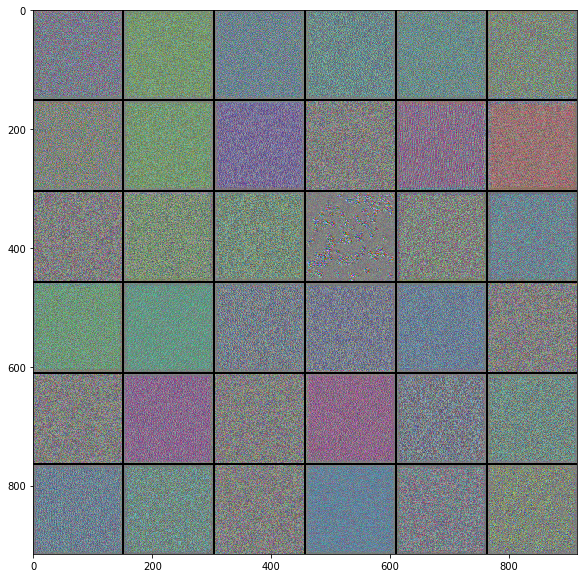

In [138]:
# Look at the first 36=6x6 filters in the Second . Size = 150

# Second layer : 'conv2d_2'
layer_name = model.layers[2].name
print(layer_name)


margin = 3
size_imag = 150

results = np.zeros(( 6*size_imag + 5* margin,  6*size_imag + 5*margin, 3))

for i in range(6):
    for j in range (6):
        filter_index = i + (j*6)
  
        filter_img = generate_pattern (layer_name, filter_index, size=size_imag)
         
        horizontal_start = i* size_imag + i*margin
        horizontal_end = horizontal_start + size_imag
        
        vertical_start = j*size_imag + j*margin
        vertical_end = vertical_start + size_imag
        
        results[horizontal_start:horizontal_end, 
                vertical_start:vertical_end, :]=filter_img
        

# Display results grid
print ( 'Layer :', layer_name, ' First 36 filters ')
print ( 'Filters vertical : 0,1,2,3,4,5,6')
plt.figure (figsize=(10,10))
plt.imshow(results.astype('uint8'))


conv2d_3
Layer : conv2d_3  First 36 filters 
Filters vertical : 0,1,2,3,4,5,6


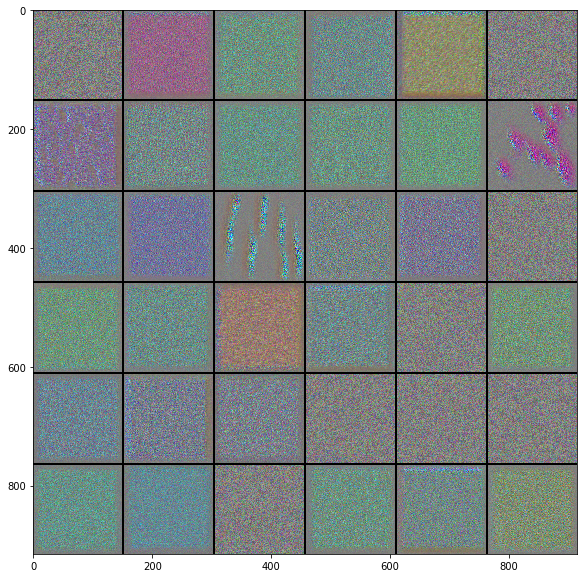

In [137]:
# Look at the first 36=6x6 filters in the Third . Size = 150

# Third layer : 'conv2d_3'
layer_name = model.layers[4].name
print(layer_name)


margin = 3
size_imag = 150

results = np.zeros(( 6*size_imag + 5* margin,  6*size_imag + 5*margin, 3))

for i in range(6):
    for j in range (6):
        filter_index = i + (j*6)
  
        filter_img = generate_pattern (layer_name, filter_index, size=size_imag)
         
        horizontal_start = i* size_imag + i*margin
        horizontal_end = horizontal_start + size_imag
        
        vertical_start = j*size_imag + j*margin
        vertical_end = vertical_start + size_imag
        
        results[horizontal_start:horizontal_end, 
                vertical_start:vertical_end, :]=filter_img
        

# Display results grid
print ( 'Layer :', layer_name, ' First 36 filters ')
print ( 'Filters vertical : 0,1,2,3,4,5,6')
plt.figure (figsize=(10,10))
plt.imshow(results.astype('uint8'))


conv2d_4
Layer : conv2d_4  First 36 filters 
Filters vertical : 0,1,2,3,4,5,6


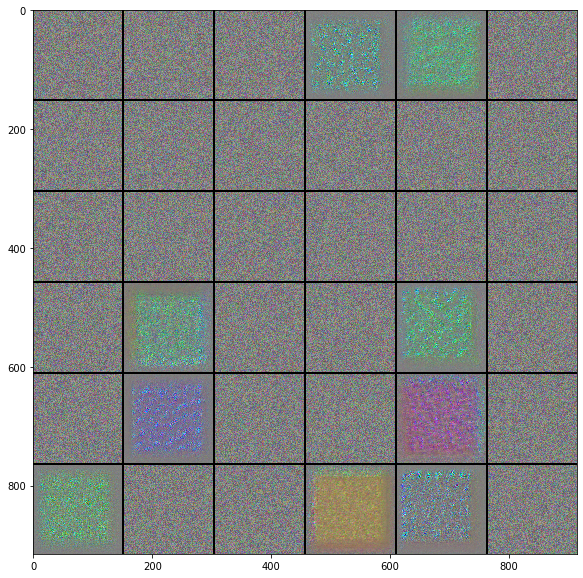

In [146]:
# Look at the first 36=6x6 filters in the Fourth conv layer . Size = 150 

# Fourth : 'conv2d_4'
layer_name = model.layers[6].name
print(layer_name)


margin = 3
size_imag = 150

results = np.zeros(( 6*size_imag + 5* margin,  6*size_imag + 5*margin, 3))

for i in range(6):
    for j in range (6):
        filter_index = i + (j*6)
  
        filter_img = generate_pattern (layer_name, filter_index, size=size_imag)
         
        horizontal_start = i* size_imag + i*margin
        horizontal_end = horizontal_start + size_imag
        
        vertical_start = j*size_imag + j*margin
        vertical_end = vertical_start + size_imag
        
        results[horizontal_start:horizontal_end, 
                vertical_start:vertical_end, :]=filter_img
        

# Display results grid
print ( 'Layer :', layer_name, ' First 36 filters ')
print ( 'Filters vertical : 0,1,2,3,4,5,6')
plt.figure (figsize=(10,10))
plt.imshow(results.astype('uint8'))



conv2d_4
Layer : conv2d_4  First 36 filters 
Filters vertical : 0,1,2,3,4,5,6


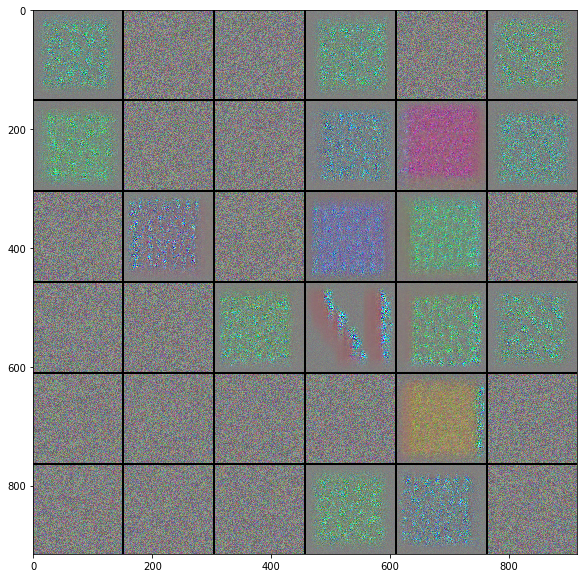

In [147]:
# Look at the first 36=6x6 filters in the Fourth conv layer . Size = 150 
# The next 36 filters

# Fourth : 'conv2d_4'
layer_name = model.layers[6].name
print(layer_name)


margin = 3
size_imag = 150

results = np.zeros(( 6*size_imag + 5* margin,  6*size_imag + 5*margin, 3))

for i in range(6):
    for j in range (6):
        filter_index = i + (j*6)+36
  
        filter_img = generate_pattern (layer_name, filter_index, size=size_imag)
         
        horizontal_start = i* size_imag + i*margin
        horizontal_end = horizontal_start + size_imag
        
        vertical_start = j*size_imag + j*margin
        vertical_end = vertical_start + size_imag
        
        results[horizontal_start:horizontal_end, 
                vertical_start:vertical_end, :]=filter_img
        

# Display results grid
print ( 'Layer :', layer_name, ' First 36 filters ')
print ( 'Filters vertical : 0,1,2,3,4,5,6')
plt.figure (figsize=(10,10))
plt.imshow(results.astype('uint8'))


In [ ]:


The idea is the following: we start with a picture containing random pixels. 
We apply the network in evaluation mode to this random image, calculate the average activation of a certain 
feature map in a certain layer from which we then compute the gradients with respect to the input image pixel 
values. Knowing the gradients for the pixel values we then proceed to update the pixel values in a way that
maximizes the average activation of the chosen feature map.

I know that this might sound confusing so let’s explain it again in different words: 
The network weights are fixed, the network will not be trained, and we try to find an image 
that maximizes the average activation of a certain feature map by performing gradient descent optimization 
on the pixel values.